# Задача 1

Для датасета Mnist с рукописными цифрами:
1. Реализуйте модель классификации без сверточных слоев (только с полносвязными). Возьмите какое-нибудь изображение из датасета, реализуйте сдвиг этого изображения на 5px влево и вправо так, чтобы визуально объект на изображении смещался. Посчитайте вероятности для каждого класса. Визуализируйте как меняются вероятности в зависимости от степени сдвига.
2. Сделайте то же самое с сетью со сверточными слоями. Сравните результаты.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_dataset  = torchvision.datasets.MNIST(root='data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)
    
model_mlp = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_mlp.parameters(), lr=0.001)

model_mlp.train()
for epoch in range(10):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_mlp(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"MLP Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

MLP Epoch 1, Loss: 1.6412
MLP Epoch 2, Loss: 1.5396
MLP Epoch 3, Loss: 1.5252
MLP Epoch 4, Loss: 1.5152
MLP Epoch 5, Loss: 1.5080
MLP Epoch 6, Loss: 1.5018
MLP Epoch 7, Loss: 1.4970
MLP Epoch 8, Loss: 1.4935
MLP Epoch 9, Loss: 1.4898
MLP Epoch 10, Loss: 1.4872


In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2,2) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2) 
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*7*7, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)
    
model_cnn = CNN().to(device)
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.AdamW(model_cnn.parameters(), lr=0.001)

model_cnn.train()
for epoch in range(10):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        outputs = model_cnn(images)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()
        running_loss += loss.item()
    print(f"CNN Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

CNN Epoch 1, Loss: 1.7037
CNN Epoch 2, Loss: 1.4938
CNN Epoch 3, Loss: 1.4834
CNN Epoch 4, Loss: 1.4792
CNN Epoch 5, Loss: 1.4766
CNN Epoch 6, Loss: 1.4745
CNN Epoch 7, Loss: 1.4728
CNN Epoch 8, Loss: 1.4722
CNN Epoch 9, Loss: 1.4707
CNN Epoch 10, Loss: 1.4702


Истинная метка: 7


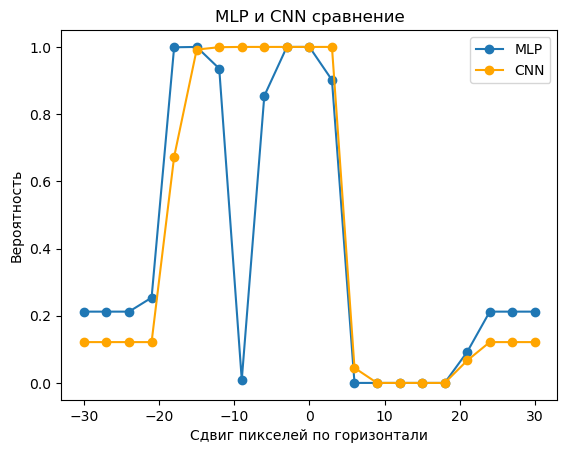

In [14]:
model_mlp.eval()
model_cnn.eval()
with torch.no_grad():
    sample_img, sample_label = test_dataset[0] 
    
sample_img_np = sample_img.squeeze().numpy()
true_label = sample_label
print("Истинная метка:", true_label)

shifts = np.arange(-30, 31, 3) 

def shift_image(img, shift_x):
    return TF.affine(img, angle=0, translate=[shift_x, 0], scale=1.0, shear=0, fill=0)

probs_mlp = []
probs_cnn = []

with torch.no_grad():
    for s in shifts:
        shifted_img = shift_image(sample_img, shift_x=int(s))
        input_img = shifted_img.unsqueeze(0).to(device)
        pred_mlp = model_mlp(input_img).cpu().numpy()[0]
        pred_cnn = model_cnn(input_img).cpu().numpy()[0]
        probs_mlp.append(pred_mlp)
        probs_cnn.append(pred_cnn)

probs_mlp = np.array(probs_mlp)
probs_cnn = np.array(probs_cnn)

plt.plot(shifts, probs_mlp[:, true_label], marker='o', label='MLP')
plt.title("MLP и CNN сравнение")
plt.xlabel("Сдвиг пикселей по горизонтали")
plt.ylabel("Вероятность")

plt.plot(shifts, probs_cnn[:, true_label], marker='o', color='orange', label='CNN')

plt.legend()
plt.show()

# Задача 2

Напишите модель классификации на предобученной сети resnet18 на Pytorch с заменой последнего полносвязного слоя для данных из [директории](https://drive.google.com/drive/folders/1r0PvRCsrqBpRe6bj1aw8bLwkEfAbC9lo?usp=sharing). Построить графики обучения и потерь.

Epoch 1: Train Loss 0.2873, Acc 0.8959 | Test Loss 5.3691, Acc 0.5357
Epoch 2: Train Loss 0.3428, Acc 0.8797 | Test Loss 1.1459, Acc 0.7643
Epoch 3: Train Loss 0.1898, Acc 0.9228 | Test Loss 0.4190, Acc 0.8357
Epoch 4: Train Loss 0.0948, Acc 0.9641 | Test Loss 0.4005, Acc 0.8214
Epoch 5: Train Loss 0.1045, Acc 0.9623 | Test Loss 0.4756, Acc 0.8071
Epoch 6: Train Loss 0.0427, Acc 0.9910 | Test Loss 0.8236, Acc 0.7500
Epoch 7: Train Loss 0.0896, Acc 0.9695 | Test Loss 0.2506, Acc 0.8929
Epoch 8: Train Loss 0.0597, Acc 0.9749 | Test Loss 0.3205, Acc 0.8857
Epoch 9: Train Loss 0.0512, Acc 0.9838 | Test Loss 0.4257, Acc 0.8643
Epoch 10: Train Loss 0.0844, Acc 0.9695 | Test Loss 0.3078, Acc 0.8929


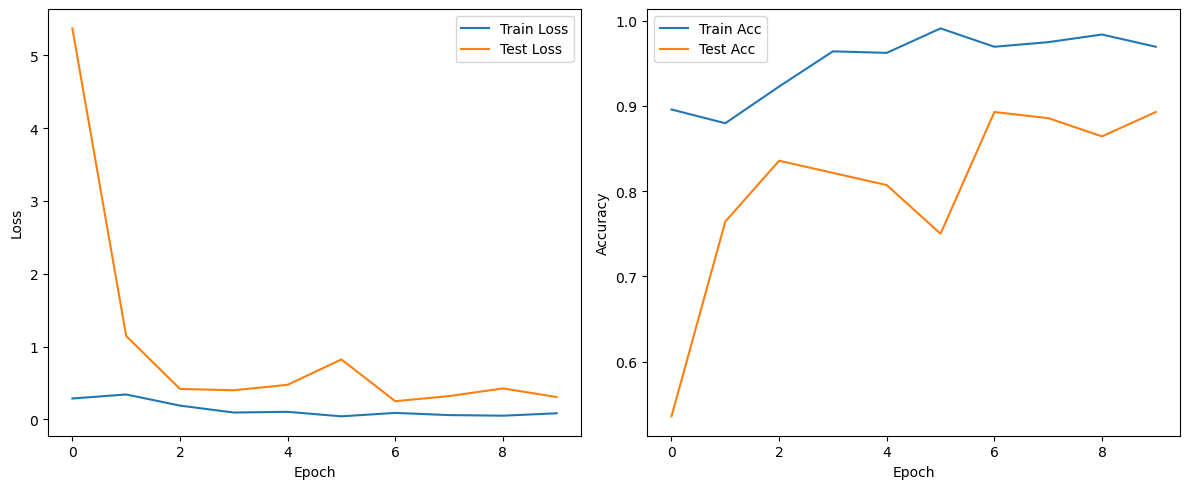

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = "data/CatsAndDogs"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform)
test_dataset = datasets.ImageFolder(f"{data_dir}/test", transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses, train_acc, test_acc = [], [], [], []

for epoch in range(10):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_losses.append(train_loss / total)
    train_acc.append(correct / total)

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    test_losses.append(test_loss / total)
    test_acc.append(correct / total)

    print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Acc {train_acc[-1]:.4f} | Test Loss {test_losses[-1]:.4f}, Acc {test_acc[-1]:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_acc, label="Train Acc")
plt.plot(test_acc, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Задача 3

Для [набора данных](https://drive.google.com/drive/folders/1sPwKGt_BX0fwGFTwVcoC7opwLT41b9Ug?usp=sharing) :
1. Изучить зависимость точности модели от разных размеров батча. Построить графики кривых обучения.
2. Изучить зависимость точности модели от разных оптимизаторов. Построить графики кривых обучения.

Epoch 1: Train Loss 0.2882, Train Acc 0.9067 | Val Loss 0.5448, Val Acc 0.8700
Epoch 2: Train Loss 0.1200, Train Acc 0.9590 | Val Loss 0.0490, Val Acc 0.9843
Epoch 3: Train Loss 0.1259, Train Acc 0.9590 | Val Loss 0.0273, Val Acc 0.9910
Epoch 4: Train Loss 0.0941, Train Acc 0.9708 | Val Loss 0.1303, Val Acc 0.9596
Epoch 5: Train Loss 0.0850, Train Acc 0.9747 | Val Loss 0.0407, Val Acc 0.9888
Epoch 6: Train Loss 0.0404, Train Acc 0.9876 | Val Loss 0.0218, Val Acc 0.9910
Epoch 7: Train Loss 0.0638, Train Acc 0.9803 | Val Loss 0.0428, Val Acc 0.9888
Epoch 8: Train Loss 0.0735, Train Acc 0.9787 | Val Loss 0.0226, Val Acc 0.9955
Epoch 9: Train Loss 0.0204, Train Acc 0.9944 | Val Loss 0.0088, Val Acc 0.9978
Epoch 10: Train Loss 0.0453, Train Acc 0.9820 | Val Loss 0.2281, Val Acc 0.9507
Epoch 1: Train Loss 0.2288, Train Acc 0.9247 | Val Loss 0.0529, Val Acc 0.9798
Epoch 2: Train Loss 0.0397, Train Acc 0.9871 | Val Loss 0.0668, Val Acc 0.9843
Epoch 3: Train Loss 0.0519, Train Acc 0.9831 | Val 

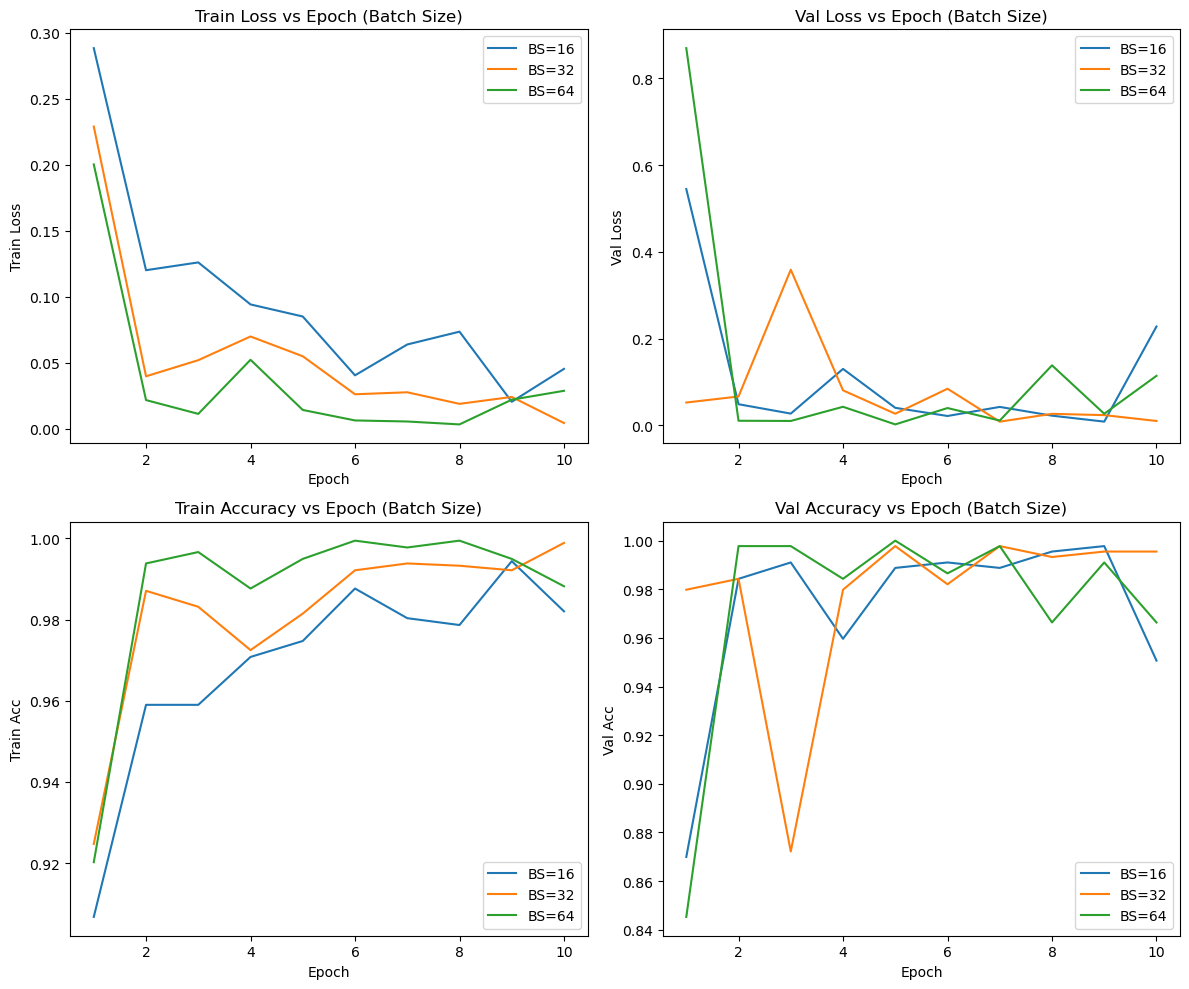

Epoch 1: Train Loss 0.2066, Train Acc 0.9208 | Val Loss 0.0763, Val Acc 0.9731
Epoch 2: Train Loss 0.0183, Train Acc 0.9921 | Val Loss 0.0394, Val Acc 0.9865
Epoch 3: Train Loss 0.0232, Train Acc 0.9927 | Val Loss 0.0709, Val Acc 0.9865
Epoch 4: Train Loss 0.0324, Train Acc 0.9910 | Val Loss 0.0008, Val Acc 1.0000
Epoch 5: Train Loss 0.0181, Train Acc 0.9938 | Val Loss 0.0003, Val Acc 1.0000
Epoch 6: Train Loss 0.0093, Train Acc 0.9972 | Val Loss 0.0133, Val Acc 0.9933
Epoch 7: Train Loss 0.0125, Train Acc 0.9972 | Val Loss 0.0014, Val Acc 1.0000
Epoch 8: Train Loss 0.0217, Train Acc 0.9927 | Val Loss 0.0027, Val Acc 1.0000
Epoch 9: Train Loss 0.0132, Train Acc 0.9961 | Val Loss 0.0098, Val Acc 0.9978
Epoch 10: Train Loss 0.0076, Train Acc 0.9955 | Val Loss 0.0013, Val Acc 1.0000
Epoch 1: Train Loss 0.2518, Train Acc 0.9208 | Val Loss 0.1054, Val Acc 0.9619
Epoch 2: Train Loss 0.0808, Train Acc 0.9725 | Val Loss 0.2684, Val Acc 0.9417
Epoch 3: Train Loss 0.0507, Train Acc 0.9843 | Val 

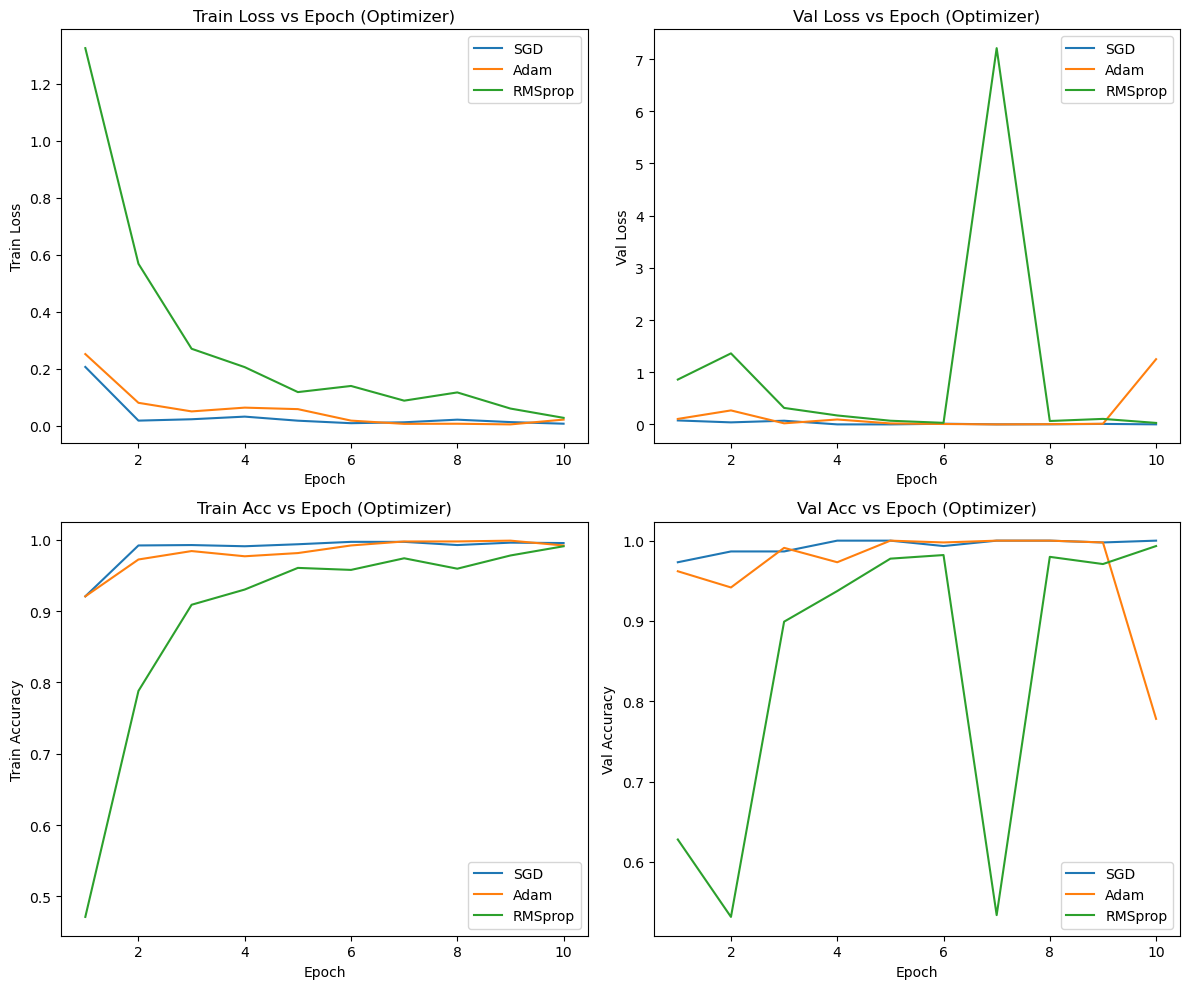

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "data/Apples"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_dataset = datasets.ImageFolder(data_dir, transform)
num_classes = len(full_dataset.classes)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

def get_dataloaders(bs):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
    return {'train': train_loader, 'val': test_loader}

def get_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
        epoch_loss = running_loss/total
        epoch_acc = running_corrects.double()/total
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc.item())
        
        model.eval()
        running_loss, running_corrects, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total += labels.size(0)
        epoch_loss = running_loss/total
        epoch_acc = running_corrects.double()/total
        val_loss_list.append(epoch_loss)
        val_acc_list.append(epoch_acc.item())
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch+1}: Train Loss {train_loss_list[-1]:.4f}, Train Acc {train_acc_list[-1]:.4f} | Val Loss {val_loss_list[-1]:.4f}, Val Acc {val_acc_list[-1]:.4f}")
    model.load_state_dict(best_model_wts)
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

batch_sizes = [16, 32, 64]
exp1 = {}
for bs in batch_sizes:
    dataloaders = get_dataloaders(bs)
    model = get_model(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    tl, ta, vl, va = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
    exp1[bs] = {'train_loss': tl, 'train_acc': ta, 'val_loss': vl, 'val_acc': va}

epochs = range(1,11)
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
for bs in batch_sizes:
    plt.plot(epochs, exp1[bs]['train_loss'], label=f'BS={bs}')
plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.title("Train Loss vs Epoch (Batch Size)")
plt.legend()
plt.subplot(2,2,2)
for bs in batch_sizes:
    plt.plot(epochs, exp1[bs]['val_loss'], label=f'BS={bs}')
plt.xlabel("Epoch"); plt.ylabel("Val Loss"); plt.title("Val Loss vs Epoch (Batch Size)")
plt.legend()
plt.subplot(2,2,3)
for bs in batch_sizes:
    plt.plot(epochs, exp1[bs]['train_acc'], label=f'BS={bs}')
plt.xlabel("Epoch"); plt.ylabel("Train Acc"); plt.title("Train Accuracy vs Epoch (Batch Size)")
plt.legend()
plt.subplot(2,2,4)
for bs in batch_sizes:
    plt.plot(epochs, exp1[bs]['val_acc'], label=f'BS={bs}')
plt.xlabel("Epoch"); plt.ylabel("Val Acc"); plt.title("Val Accuracy vs Epoch (Batch Size)")
plt.legend()
plt.tight_layout()
plt.show()

optimizers_dict = {
    "SGD": lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    "Adam": lambda params: optim.AdamW(params, lr=0.001),
    "RMSprop": lambda params: optim.RMSprop(params, lr=0.001)
}
dataloaders = get_dataloaders(32)
exp2 = {}
for opt_name, opt_fn in optimizers_dict.items():
    model = get_model(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = opt_fn(model.parameters())
    tl, ta, vl, va = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
    exp2[opt_name] = {'train_loss': tl, 'train_acc': ta, 'val_loss': vl, 'val_acc': va}

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
for opt_name in optimizers_dict.keys():
    plt.plot(epochs, exp2[opt_name]['train_loss'], label=opt_name)
plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.title("Train Loss vs Epoch (Optimizer)")
plt.legend()
plt.subplot(2,2,2)
for opt_name in optimizers_dict.keys():
    plt.plot(epochs, exp2[opt_name]['val_loss'], label=opt_name)
plt.xlabel("Epoch"); plt.ylabel("Val Loss"); plt.title("Val Loss vs Epoch (Optimizer)")
plt.legend()
plt.subplot(2,2,3)
for opt_name in optimizers_dict.keys():
    plt.plot(epochs, exp2[opt_name]['train_acc'], label=opt_name)
plt.xlabel("Epoch"); plt.ylabel("Train Accuracy"); plt.title("Train Acc vs Epoch (Optimizer)")
plt.legend()
plt.subplot(2,2,4)
for opt_name in optimizers_dict.keys():
    plt.plot(epochs, exp2[opt_name]['val_acc'], label=opt_name)
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy"); plt.title("Val Acc vs Epoch (Optimizer)")
plt.legend()
plt.tight_layout()
plt.show()